# Building and using a 0D emulator

This notebook demonstrates how to use the `cardioemulator` library to:

- build a zero-dimensional emulator ($\mathcal{M}_{\text{0D}}$) of a three-dimensional left ventricular model ($\mathcal{M}_{\text{3D}}$);

- perform numerical simulations through the zero-dimensional emulator;

- use the zero-dimensional emulator to detect a limit cycle.

The file used in this demo are contained in the folder `example` of the repository [repository](https://github.com/FrancescoRegazzoni/cardioemulator).

## Building the 0D emulator

Let us first import the needed dependencies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys

# you don't need this line if you have installed cardioemulator correctly!
sys.path.insert(0, '..') 

import cardioemulator

The file `example/data/sample_PV_loops.csv` contains five PV loops obtained through the 3D left ventricle (LV) model, coupled with a circulation model ($\mathcal{M}_{\text{3D}}$-$\mathcal{C}$).
The file `example/data/simulated_EDPVR.csv` contains pressure-volume pairs in relaxed conditions, obtained with the same 3D left ventricle model ($\mathcal{M}_{\text{3D}}$).

With the following commands, we build two emulators. The first one is based on the *fitted EDPVR approach* (that is, the EDPV relationship is obtained by fitting the Klotz's curve on the sample PV loops).


In [2]:
emulator_fitted_EDPV = cardioemulator.build_emulator(
                            file_PV_loops = 'data/sample_PV_loops.csv',
                            period = 0.8, # [s]
                            num_cycles = 3)

Building 0D emulator:
   file PV loops:         data/sample_PV_loops.csv
   EDPV approach:         fitted
   period:                0.800 s
   num cycles:            3
   EDPV V_0:              -1.19 mL
   EDPV V_30:             167.47 mL
   ESPV V_0:              11.45 mL
   ESPV elastance:        1.645 mmHg/mL
   EDPV elastance:        0.132 mmHg/mL


The second one is based on the *simulated EDPVR approach* (that is the EDPV relationship is obtained through the 3D model).

In [3]:
emulator_simulated_EDPV = cardioemulator.build_emulator(
                            file_PV_loops = 'data/sample_PV_loops.csv',
                            file_EDPV = 'data/simulated_EDPVR.csv', 
                            period = 0.8, # [s]
                            num_cycles = 3)

Building 0D emulator:
   file PV loops:         data/sample_PV_loops.csv
   EDPV approach:         simulated
   file EDPV:             data/simulated_EDPVR.csv
   period:                0.800 s
   num cycles:            3
   ESPV V_0:              11.45 mL
   ESPV elastance:        1.645 mmHg/mL
   EDPV elastance:        0.132 mmHg/mL


<div class="alert alert-info">

**Note**

These commands assume that pressures and volumes are contained in columns named "pressure" and "volume", respectively.
If this is not the case, you can specify the column names through the arguments `label_pressure_PV_loops` and `label_volume_PV_loops` (for `file_PV_loops`), or `label_pressure_EDPV` and `label_volume_PV_EDPV` (for `file_EDPV`).
Similarly, you can change the dafault measure units (mmHg and mL, respectively), through the arguments `pressure_unit_PV_loops`, `volume_unit_PV_loops`, `pressure_unit_EDPV` and `volume_unit_EDPV`.

</div>

Please notice that the same results can be obtained by running the bash command:
```bash
$ cardioemulator_build data/sample_PV_loops.csv 0.8 --num-cycles 3 \
                       -o emulator_fitted_EDPV.json
$ cardioemulator_build data/sample_PV_loops.csv 0.8 --num-cycles 3 \
                       --EDPV data/simulated_EDPVR.csv \
                       -o emulator_simulated_EDPV.json
```

and then loading the emulators from file within a Python script:
```python
emulator_fitted_EDPV    = cardioemulator.Emulator('emulator_fitted_EDPV.json')
emulator_simulated_EDPV = cardioemulator.Emulator('emulator_simulated_EDPV.json')
```

<div class="alert alert-info">

**Hint**

The option ``-d`` of the app ``cardioemulator_build`` provides on-the-fly plots of the emulator built.
Similarly, the argument ``-f`` allows to export the figure to file.

</div>


## Visualizing the 0D emulator

Let us plot the functions defining the two emulators $\mathcal{M}_{\text{0D}}$, together with the PV loops we used for their construction.

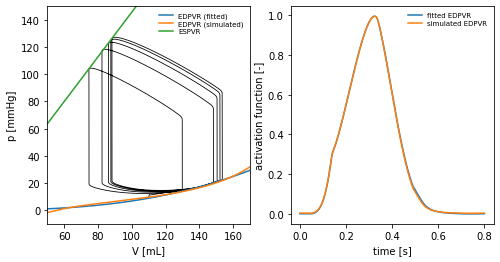

In [4]:
data_loop = pd.read_csv('data/sample_PV_loops.csv')
VV = np.linspace(20, 200, 1000)
times = np.linspace(0, 0.8, 1000)

_, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].plot(data_loop.volume, data_loop.pressure, 'k', linewidth = 0.8)
axs[0].plot(VV, emulator_fitted_EDPV.EDPV(VV), label = 'EDPVR (fitted)')
axs[0].plot(VV, emulator_simulated_EDPV.EDPV(VV), label = 'EDPVR (simulated)')
axs[0].plot(VV, emulator_fitted_EDPV.ESPV(VV), label = 'ESPVR')
axs[0].set_xlabel('V [mL]')
axs[0].set_ylabel('p [mmHg]')
axs[0].set_xlim([50, 170])
axs[0].set_ylim([-10, 150])
axs[0].legend(bbox_to_anchor=(1, 1), loc=1, frameon=False, fontsize=7, labelspacing = 0.2)
axs[1].plot(times, emulator_fitted_EDPV.activation(times), label = 'fitted EDPVR')
axs[1].plot(times, emulator_simulated_EDPV.activation(times), label = 'simulated EDPVR')
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('activation function [-]')
axs[1].legend(bbox_to_anchor=(1, 1), loc=1, frameon=False, fontsize=7, labelspacing = 0.2)


## Using the 0D emulator

The 0D emulator consists of a time-dependent pressure-volume relationship:
\begin{equation}
p = \mathcal{P}(V, t)
\end{equation}
The pressure-volume function $\mathcal{P}$ is accessible through the member [PV](../docs/_autosummary/_autosummary/cardioemulator.Emulator.html#cardioemulator.Emulator.PV) of the class [Emulator](../_autosummary/_autosummary/cardioemulator.Emulator.html). The following script computes e.g. $\mathcal{P}(100 \text{ mL}, 0.4 \text{ s})$


In [5]:
volume = 100 # [ml]
time = 0.4 # [s]
pressure = emulator_fitted_EDPV.PV(volume, time)
print('pressure = %f mmHg' % pressure)

pressure = 91.256128 mmHg


A useful feature of the 0D emulator is the possibilty of being coupled with a blood circulation model ($\mathcal{C}$).
For illutrative purposes, this example contains a Python class implementing the 0D closed-loop circulation model introduced in [this paper](https://arxiv.org/abs/2011.15040). To couple the 0D emulator with this circulation model, all we need to do is simply replacing the LV pressure-volume relationship (therein represented by an elastance-based model) by the function $\mathcal{P}$ and then running a simulation:

In [6]:
from circulation_closed_loop import circulation_closed_loop

# initialize the circulation model
circulation = circulation_closed_loop(options = 'data/params_bsln.json')
# replace the original LV PV relationship with the one defined by the emulator
circulation.p_LV_func = emulator_fitted_EDPV.PV
# run a 5 heartbeats simulation
history = circulation.solve(num_cycles = 5, initial_state = 'data/state_bsln.json')

Circulation model - running simulation...
Circulation model - elapsed time 2.0310 s


Let us now visually compare the results obtanined with the $\mathcal{M}_{\text{0D}}$-$\mathcal{C}$ model and with the $\mathcal{M}_{\text{3D}}$-$\mathcal{C}$ model:

Text(0, 0.5, 'p [mmHg]')

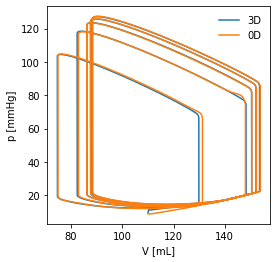

In [7]:
_, axs = plt.subplots(1,1,figsize=(4,4))
axs.plot(data_loop.volume, data_loop.pressure, label = '3D')
axs.plot(history.VLV, history.pLV, label = '0D')
axs.legend(bbox_to_anchor = (1, 1), loc = 1, frameon = False)
axs.set_xlabel('V [mL]')
axs.set_ylabel('p [mmHg]')

## Detecting the limit cycle by means of the 0D emulator

Let us now run 100 heartbeats by means of the 0D emulator coupled with the circulation model ($\mathcal{M}_{\text{0D}}$-$\mathcal{C}$).
Then, we store the final state of this simulation in the file `limit_cycle.json`.
Finally, to check that the simulation actually reached a limit cycle, we perform a second and shorter simulation starting from the stored state.

In [8]:
history_transient = circulation.solve(num_cycles = 100, initial_state = 'data/state_bsln.json')
circulation.save_state('limit_cycle.json')
history_limit_cycle = circulation.solve(num_cycles = 3, initial_state = 'limit_cycle.json')

Circulation model - running simulation...
Circulation model - elapsed time 39.8512 s
Circulation model - running simulation...
Circulation model - elapsed time 1.2790 s


Let us plot the full transient and the limit cycle:

Text(0, 0.5, 'p [mmHg]')

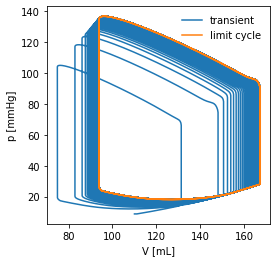

In [9]:
_, axs = plt.subplots(1,1,figsize=(4,4))
axs.plot(history_transient.VLV, history_transient.pLV, label = 'transient')
axs.plot(history_limit_cycle.VLV, history_limit_cycle.pLV, label = 'limit cycle')
axs.legend(bbox_to_anchor = (1, 1), loc = 1, frameon = False)
axs.set_xlabel('V [mL]')
axs.set_ylabel('p [mmHg]')

In conclusion, the final state of the simulation obtained through the $\mathcal{M}_{\text{0D}}$-$\mathcal{C}$ model (stored in the file `limit_cycle.json`) can be used to provide an initial state for the $\mathcal{M}_{\text{3D}}$-$\mathcal{C}$ model. Specifically, the state variables of the circulation model allow to initialize the circulation model itself, while the pressure or volume of the LV allow to initialize the $\mathcal{M}_{\text{3D}}$ model. The results are reported in \[1\].

### References

\[1\] F. Regazzoni, A. Quarteroni "[Accelerating the convergence to a limit cycle in 3D cardiac electromechanical simulations through a data-driven 0D emulator](https://www.mate.polimi.it/biblioteca/add/qmox/35-2021.pdf)", *Computers in Biology and Medicine* (2021)